Brandon Connors  
11/5/23  
Practical Dashboards

In [1]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Pipeline Code for Professor's Review

```
[
    {
        '$project': {
            'id': '$id', 
            'title': '$title', 
            'runtime': {
                '$convert': {
                    'input': '$runtime', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'user_rating': {
                '$convert': {
                    'input': '$user_rating', 
                    'to': 'double', 
                    'onError': None
                }
            }, 
            'votes': {
                '$convert': {
                    'input': '$votes', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'mpaa_rating': {
                '$split': [
                    '$mpaa_rating', '::'
                ]
            }, 
            'release_date': {
                '$convert': {
                    'input': '$release_date', 
                    'to': 'date', 
                    'onError': None
                }
            }, 
            'budget': {
                '$convert': {
                    'input': '$budget', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'opening_weekend': {
                '$convert': {
                    'input': '$opening_weekend', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'gross_sales': {
                '$convert': {
                    'input': '$gross_sales', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'genres': {
                '$split': [
                    {
                        '$toString': '$genres'
                    }, ', '
                ]
            }, 
            'cast': {
                '$split': [
                    {
                        '$toString': '$cast'
                    }, ', '
                ]
            }, 
            'director': {
                '$split': [
                    {
                        '$toString': '$director'
                    }, ', '
                ]
            }, 
            'producer': {
                '$split': [
                    {
                        '$toString': '$producer'
                    }, ', '
                ]
            }, 
            'company': {
                '$split': [
                    {
                        '$toString': '$company'
                    }, ', '
                ]
            }
        }
    }, {
        '$addFields': {
            'slimmed_rating': {
                '$arrayElemAt': [
                    '$mpaa_rating', 0
                ]
            }, 
            'release_year': {
                '$year': '$release_date'
            }, 
            'release_month': {
                '$month': '$release_date'
            }
        }
    }
]
```

### Importing the Connection String

In [3]:
import json

# Loading the json file that contains the connection string
with open('D:\\School\\Fall 2023\\secrets.json') as d:
    data = json.load(d)

    # Extracting the connection string from the file
    connectionString = data['mongodbRead']

# Sanity check to make sure that I've pulled the right data
print(f"My connection string is {len(connectionString)} characters in length.")

My connection string is 73 characters in length.


### Connecting to the Database

In [6]:
# This section is originally from the professor's sample code that I used in the previous assignment

import pymongo
import certifi

# Connect to the database using known good certificates
client = pymongo.MongoClient(connectionString, tlsCAFile=certifi.where())

# Fetch the database named "DA320"
da320_database = client['DA320']

### Comparing User Ratings by Genre

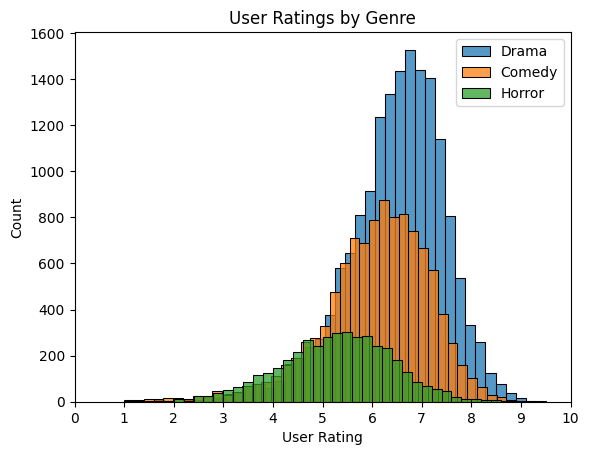

In [73]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Executing a query where I pull all the movies that have "comedy" listed as one of its generes and producing a cursor
cursorComedy = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Comedy']}})

# Converting the information retrieved into a Pandas dataframe
imdbComedy = pd.DataFrame(cursorComedy)

# Executing a query pulling all the movies that have "horror" listed as one of its genres and producing a cursor and then converting the information retrieved into a Pandas dataframe
cursorHorror = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Horror']}})
imdbHorror = pd.DataFrame(cursorHorror)

# Executing a query pulling all the movies that have "drama" listed as one of its genres and producing a cursor and then converting the information retrieved into a Pandas dataframe
cursorDrama = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Drama']}})
imdbDrama = pd.DataFrame(cursorDrama)

# Plotting the three dataframes into a single histogram to be able to easily compare them
ax = sns.histplot(data=imdbDrama, x="user_rating", binwidth=0.2, label="Drama")
sns.histplot(data=imdbComedy, x="user_rating", binwidth=0.2, label="Comedy")
sns.histplot(data=imdbHorror, x="user_rating", binwidth=0.2, label="Horror")
# Formats the plot to be a little easier to read
ax.set(title="User Ratings by Genre", xticks=[0,1,2,3,4,5,6,7,8,9,10], xlabel="User Rating")
# Ensures the legend gets displayed so you can tell which colors mean what
_ = ax.legend()



### Comparing Gross Sales to MPAA/TV Rating

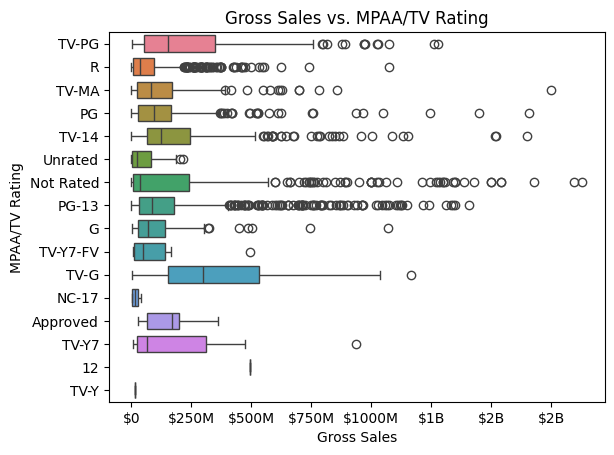

In [88]:
# Executing a query of all the movies that have a gross sales amount listed and is less than 2e9, which I found through experimentation to exclude any significant outliers that could be the result of currency issues discovered in the previous assignment
grossSalesCursor = da320_database["IMDB_Pipeline_View"].find({'gross_sales': {'$lt': 2e9}})
imdbGrossSales = pd.DataFrame(grossSalesCursor)

# A custom formatter for currency, this code copied from the professor's sample code
def format_currency(amount, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"


# Plotting the data on a box plot to show the average ranges (and outliers) of the sales when broken down by MPAA/TV Rating, uses the currency formatter to change the display on the x-axis
ax = sns.boxplot(data=imdbGrossSales, x="gross_sales", y="slimmed_rating", gap=.1, hue="slimmed_rating", legend=False)
ax.set(title="Gross Sales vs. MPAA/TV Rating", xlabel="Gross Sales", ylabel="MPAA/TV Rating")
plt.gca().xaxis.set_major_formatter(format_currency)


### Comparing Budget to Release Month for Action Movies

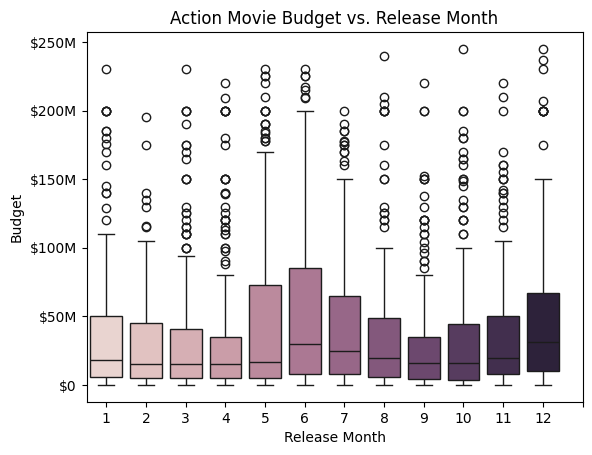

In [100]:
# Executing a query of all the action movies that have a budget amount listed and is less than 2.5e8
budgetCursor = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Action']}, 'budget': {'$lt': 2.5e8}})
imdbBudget = pd.DataFrame(budgetCursor)

# Plotting the data on a box plot to show the average ranges (and outliers) of the budgets of action movies for each of the release months, uses the currency formatter from the previous code block to change the display on the y-axis
ax = sns.boxplot(data=imdbBudget, x="release_month", y="budget", hue="release_month", legend=False)
ax.set(title="Action Movie Budget vs. Release Month", xlabel="Release Month", ylabel="Budget", xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.gca().yaxis.set_major_formatter(format_currency)

### Takeaways

I learned a few things playing around with the data, although in retrospect most of the things I learned were not that surprising.  

For my first chart, I decided I wanted to compare a couple of genres and see if there was a noticable difference between how they tended to be rated on IMDb. The result wasn't too surprising, with the scores given to dramas tending to be closer together and higher on average than those of comedies. Both of which really demonstrate how varied the reviews tend to be when it comes to horror films. As a fan of what most would consider bad films, they tend to be either action or horror, and so seeing that the scores of horror movies tend to be more spread out makes a lot of sense to me.  

When I made the second chart, I wanted to see how different films performed when you take their ratings into account. Looking at the plot, I can really understand why major studios tend to prefer making films that are rated in a way that whole families can attend, those films in general tend to make more money than those that are rated "R" for instance.  

Now, with the last chart, I was curious about action films, and how their budgets tendend to be when you compare it to the release month. When you look at the graph, you can really see a trend of when movie studios like to release their bigger budget films, most notably late Spring/early Summer, as well as the holiday season.  

When you compare the information presented in the last two charts, it makes sense that late Spring/early Summer and the Holidays are when studios like to release their biggest budget films, as those are the times that families are more likely able to watch movies in theaters together, with children being more likely to be out of school. I think an interesting follow-up chart (that I currently don't have time to explore if I want to get this assignment in on time) could be release month vs. MPAA/TV Rating, that way one could see if more family friendly films have significantly higher frequency of releasing during those peak months, or inversely, if more mature films don't fluctuate as much, since their intended audiences don't have the same restrictions.
